In [45]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os


In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose whether to use gpu or cpu

In [85]:
# data_dir = r'C:\Users\Public\PartIIB project 2023_2024\Image collection without reaction\00AgNO3_mole_fraction\Outputs_Grayscale_Labelled_Images_Sizes\size_folder'  #path to the folder containing the images
# data_dir = r'C:\Users\Public\PartIIB project 2023_2024\PastData\helical_size'
first_dir = r'C:\Users\Public\PartIIB project 2023_2024\Image collection without reaction\00AgNO3_mole_fraction\Outputs_Grayscale_Labelled_Images_Sizes\size_folder\first_half\first_quarter'     #Bruno's computer
second_dir = r'C:\Users\Public\PartIIB project 2023_2024\Image collection without reaction\00AgNO3_mole_fraction\Outputs_Grayscale_Labelled_Images_Sizes\size_folder\first_half\second_quarter'
third_dir = r'C:\Users\Public\PartIIB project 2023_2024\Image collection without reaction\00AgNO3_mole_fraction\Outputs_Grayscale_Labelled_Images_Sizes\size_folder\second_half\third_quarter'
fourth_dir = r'C:\Users\Public\PartIIB project 2023_2024\Image collection without reaction\00AgNO3_mole_fraction\Outputs_Grayscale_Labelled_Images_Sizes\size_folder\second_half\fourth_quarter'

# first_dir = r'C:\Users\Chappyyyyyy\Documents\size_folder\first_half\first_quarter' #chappy computer
# second_dir = r'C:\Users\Chappyyyyyy\Documents\size_folder\first_half\second_quarter'
# third_dir = r'C:\Users\Chappyyyyyy\Documents\size_folder\second_half\third_quarter'
# fourth_dir = r'C:\Users\Chappyyyyyy\Documents\size_folder\second_half\fourth_quarter'

# first_dir = r"C:\Users\Public\PartIIB project 2023_2024\PastData\AgNO3Helical_size\first_quarter"
# second_dir = r"C:\Users\Public\PartIIB project 2023_2024\PastData\AgNO3Helical_size\second_quarter"
# third_dir = r"C:\Users\Public\PartIIB project 2023_2024\PastData\AgNO3Helical_size\third_quarter"
# fourth_dir = r"C:\Users\Public\PartIIB project 2023_2024\PastData\AgNO3Helical_size\fourth_quarter"

# first_dir = r"C:\Users\Public\PartIIB project 2023_2024\Image collection without reaction\00MultiConc\Outputs_Grayscale_Labelled_Images_Sizes\full_folder\first_quarter\size_folder"
# second_dir = r"C:\Users\Public\PartIIB project 2023_2024\Image collection without reaction\00MultiConc\Outputs_Grayscale_Labelled_Images_Sizes\full_folder\second_quarter\size_folder"
# third_dir = r"C:\Users\Public\PartIIB project 2023_2024\Image collection without reaction\00MultiConc\Outputs_Grayscale_Labelled_Images_Sizes\full_folder\third_quarter\size_folder"
# fourth_dir = r"C:\Users\Public\PartIIB project 2023_2024\Image collection without reaction\00MultiConc\Outputs_Grayscale_Labelled_Images_Sizes\full_folder\fourth_quarter\size_folder"


In [86]:
# multi-input dataset
class CustomImageDataset(Dataset):
    def __init__(self, first_dir, second_dir, third_dir, fourth_dir, transform=None):
        self.first_dir = first_dir
        self.second_dir = second_dir
        self.third_dir = third_dir
        self.fourth_dir = fourth_dir
        self.transform = transform
        # self.images1 = sorted(os.listdir(first_dir))
        self.images1 = sorted(os.listdir(first_dir), key=self.custom_sort_key)
        self.images2 = sorted(os.listdir(second_dir), key=self.custom_sort_key)
        self.images3 = sorted(os.listdir(third_dir), key=self.custom_sort_key)
        self.images4 = sorted(os.listdir(fourth_dir), key=self.custom_sort_key)
        self.labels1 = [self.extract_label(img) for img in self.images1]
        self.labels2 = [self.extract_label(img) for img in self.images2]
        self.labels3 = [self.extract_label(img) for img in self.images3]
        self.labels4 = [self.extract_label(img) for img in self.images4]
        self.cuttime = [self.extract_cuttime(img) for img in self.images1]
        
        #input verification
        assert len(self.images1) == len(self.images2) == len(self.images3) == len(self.images4)

        self.length = len(self.images1)

    def __len__(self):
        return self.length
        # return len(self.images1)

    def __getitem__(self, idx):
        img_name1 = os.path.join(self.first_dir, self.images1[idx])
        image1 = Image.open(img_name1)
        img_name2 = os.path.join(self.second_dir, self.images2[idx])
        image2 = Image.open(img_name2)
        img_name3 = os.path.join(self.third_dir, self.images3[idx])
        image3 = Image.open(img_name3)
        img_name4 = os.path.join(self.fourth_dir, self.images4[idx])
        image4 = Image.open(img_name4)
    
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
            image3 = self.transform(image3)
            image4 = self.transform(image4)
        
        # print(self.labels1)
        # print(self.labels2)
        # print(self.labels3)
        # print(self.labels4)

        label1 = self.labels1[idx]
        label2 = self.labels2[idx]
        label3 = self.labels3[idx]
        label4 = self.labels4[idx]
        cuttime = self.cuttime[idx]
        return image1, image2, image3, image4, label1, label2, label3, label4, cuttime

    def custom_sort_key(self, item):
        # Extract numbers after 'Fig_' and 't-'
        fig_number = float(item.split('Fig_')[1].split('__')[0])
        t_number = float(item.split('t-')[1].split('_')[0])
        
        return fig_number, t_number
    
    def extract_label(self, img_name):
        # Assuming that the label is part of the filename before the first underscore
        # label = str(img_name)
        # print(label)

        label = float(img_name[-17:-5]) #this is the right code
        # print(label)

            
        return label
    
    def extract_cuttime(self, img_name):
        cuttime = float(img_name.split("t-")[1].split("_")[0])
        return cuttime

In [87]:
data_transform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize((0.45), (0.225))]) 

custom_dataset = CustomImageDataset(first_dir=first_dir, second_dir=second_dir, third_dir=third_dir, fourth_dir=fourth_dir, transform=data_transform)

# # Accessing the data
# for img, label in custom_dataset:
#     print(f"Image shape: {img.shape}, Label: {label}")

print(len(custom_dataset))

# train_set, val_set, test_set = random_split(custom_dataset, [int(len(custom_dataset)*0.75), int(len(custom_dataset)*0.15), int(len(custom_dataset)*0.100056)]) #splits data into training, validation and test sets
train_set, test_set = random_split(custom_dataset, [int(len(custom_dataset)*0.75), int(len(custom_dataset)*0.25013)])
print(len(train_set))
# print(len(val_set))
print(len(test_set))

5400
4050
1350


In [88]:
#hyperparameters
num_epochs = 60
batch_size = 1
learning_rate = 0.0005


train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test = DataLoader(test_set, batch_size=batch_size, shuffle=True)
for (images1, images2, images3, images4, labels1, labels2, labels3, labels4, cuttime) in train:
    print(labels1.item(), labels2.item(), labels3.item(), labels4.item(), cuttime.item())
    break

3.622631 7.965862 8.504584 7.444281 45.0


In [89]:
class ConvNet(nn.Module): # note need to find out image size
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1,8,10, padding='same') #in_channels, out_channels, kernel_size
        self.normalise1 = nn.BatchNorm2d(8)
        # self.pool1 = nn.AvgPool2d(10, stride=10)
        self.pool1 = nn.AvgPool2d(10, stride=10)
        self.conv2 = nn.Conv2d(8, 16, 10, padding='same')
        self.normalise2 = nn.BatchNorm2d(16)
        # self.pool2 = nn.AvgPool2d(2, stride=2)
        self.pool2 = nn.AvgPool2d(2, stride=2)
        self.pool3 = nn.AvgPool2d(1, stride=1)
        self.conv3 = nn.Conv2d(16, 32, 10, padding='same')
        self.normalise3 = nn.BatchNorm2d(32) 
        self.conv4 = nn.Conv2d(32, 32, 10, padding='same')
        self.fc0 = nn.Linear(32*5*5, 400)

        self.convcomb1 = nn.Conv2d(1, 16, 20, padding='same')
        self.convcomb2 = nn.Conv2d(16, 32, 20, padding='same')
        
        self.fc1 = nn.Linear(3200+40, 1600)
        self.fc2 = nn.Linear(1600,800)
        self.fc3 = nn.Linear(800,400)
        self.fc4 = nn.Linear(400,200)
        self.fc5 = nn.Linear(200,50)
        self.fc6 = nn.Linear(50,4)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(1,1)


    def forward(self, x, y, z, a, t):
        x = self.pool1(F.relu(self.normalise1(self.conv1(x)))) 
        x = self.pool2(F.relu(self.normalise2(self.conv2(x)))) 
        x = self.pool3(F.relu(self.normalise3(self.conv3(x))))
        x = self.pool3(F.relu(self.normalise3(self.conv4(x))))
        x = torch.flatten(x)  #flatten
        # print(x.shape)
        x = self.fc0(x)

        y = self.pool1(F.relu(self.normalise1(self.conv1(y)))) 
        y = self.pool2(F.relu(self.normalise2(self.conv2(y)))) 
        y = self.pool3(F.relu(self.normalise3(self.conv3(y))))
        y = self.pool3(F.relu(self.normalise3(self.conv4(y))))
        y = torch.flatten(y)  #flatten
        # print(y.shape)
        y = self.fc0(y)

        z = self.pool1(F.relu(self.normalise1(self.conv1(z))))
        z = self.pool2(F.relu(self.normalise2(self.conv2(z)))) 
        z = self.pool3(F.relu(self.normalise3(self.conv3(z))))
        z = self.pool3(F.relu(self.normalise3(self.conv4(z))))
        z = torch.flatten(z)  #flatten
        z = self.fc0(z)

        a = self.pool1(F.relu(self.normalise1(self.conv1(a)))) 
        a = self.pool2(F.relu(self.normalise2(self.conv2(a))))
        a = self.pool3(F.relu(self.normalise3(self.conv3(a))))
        a = self.pool3(F.relu(self.normalise3(self.conv4(a))))
        a = torch.flatten(a) #flatten
        a = self.fc0(a)
        # print(a.shape)

        combined = torch.stack([x,y,z,a])
        combined = combined.unsqueeze(0)
        combined= combined.unsqueeze(0)
        # print(combined.shape)
        # print(combined)
        combined = self.pool2(F.relu(self.normalise2(self.convcomb1(combined)))) 
        # print(combined.shape)
        # print(combined)
        combined = self.pool2(F.relu(self.normalise3(self.convcomb2(combined)))) 
        # combined = combined.view(-1, 32*5*5)  #flatten
        combined = torch.flatten(combined)
        # print(combined.shape)
        t = self.fc(t)
        t = torch.flatten(t.repeat(1,40))
        # print(t.shape)
        # print(t)
        combined = torch.cat((combined, t), 0)
        combined = F.relu(self.fc1(combined))
        combined = F.relu(self.fc2(combined))
        combined = F.relu(self.fc3(combined))
        combined = F.relu(self.fc4(combined))
        combined = F.relu(self.fc5(combined))
        combined = self.fc6(combined)
        return combined

In [90]:
model = ConvNet().to(device)

# loss and optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)
#training loop
n_total_steps = len(train)
for epoch in range(num_epochs):
    total_loss = 0
    for i, (images1, images2, images3, images4, labels1, labels2, labels3, labels4, cuttimes) in enumerate(train):
        images1 = images1.to(device)
        images2 = images2.to(device)
        images3 = images3.to(device)    
        images4 = images4.to(device)
        labels1 = labels1.to(device)
        labels2 = labels2.to(device)
        labels3 = labels3.to(device)
        labels4 = labels4.to(device)
        cuttimes = cuttimes.to(device).float()

        #forward
        outputs = model(images1, images2, images3, images4, cuttimes)
        # print(labels)
        labels1 = labels1.float() 
        labels2 = labels2.float()
        labels3 = labels3.float()
        labels4 = labels4.float()
        labels = torch.cat((labels1, labels2, labels3, labels4), dim=0)
        loss = criterion(outputs, labels)

        #backward
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        # if (i+1) % 1000 ==0:
        # print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')
        total_loss += loss.item()
    print(f'epoch {epoch+1}/{num_epochs}, average loss = {total_loss/len(train):.4f}')
            


epoch 1/60, average loss = 56.2345
epoch 2/60, average loss = 41.6318
epoch 3/60, average loss = 32.6446
epoch 4/60, average loss = 27.2768
epoch 5/60, average loss = 24.4319
epoch 6/60, average loss = 22.5308
epoch 7/60, average loss = 21.7703
epoch 8/60, average loss = 20.6343
epoch 9/60, average loss = 20.2973
epoch 10/60, average loss = 19.5619
epoch 11/60, average loss = 19.3471
epoch 12/60, average loss = 19.0063
epoch 13/60, average loss = 18.7182
epoch 14/60, average loss = 18.3797
epoch 15/60, average loss = 18.0577
epoch 16/60, average loss = 18.0587
epoch 17/60, average loss = 17.8934
epoch 18/60, average loss = 17.6124
epoch 19/60, average loss = 17.5845
epoch 20/60, average loss = 17.2676
epoch 21/60, average loss = 17.3495
epoch 22/60, average loss = 17.2903
epoch 23/60, average loss = 17.2240
epoch 24/60, average loss = 16.9117
epoch 25/60, average loss = 17.0619
epoch 26/60, average loss = 16.7896
epoch 27/60, average loss = 16.5029
epoch 28/60, average loss = 16.4569
e

RMSE = tensor([3.2281], dtype=torch.float64)
[7.985589981079102, 9.420445442199707, 7.1262102127075195, 6.033612251281738, 5.642982482910156, 21.105300903320312, 17.000335693359375, 15.748000144958496, 12.248476028442383, 12.925846099853516, 14.769055366516113, 15.730905532836914, 29.751054763793945, 20.635108947753906, 14.846855163574219, 11.695918083190918, 7.586102485656738, 9.365076065063477, 9.453316688537598, 8.511185646057129, 30.078405380249023, 28.95413589477539, 25.985769271850586, 21.37378692626953, 27.732187271118164, 15.637385368347168, 11.775705337524414, 10.277586936950684, 9.062460899353027, 12.363630294799805, 12.894917488098145, 11.823899269104004, 14.662530899047852, 16.651329040527344, 9.948736190795898, 8.361711502075195, 9.585861206054688, 8.171342849731445, 7.7922444343566895, 8.385502815246582, 6.9036078453063965, 6.424615383148193, 6.136623382568359, 6.144659042358398, 10.559822082519531, 9.665024757385254, 9.506997108459473, 9.685931205749512, 12.0109910964965

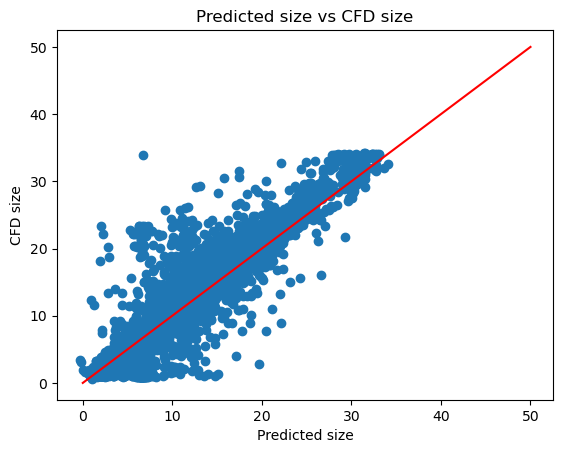

In [91]:
#Testing
with torch.no_grad(): # no need to calculate gradient
    squared_difference = 0
    predicted_size_data = []
    CFD_size_data = []
    for (images1, images2, images3, images4, labels1, labels2, labels3, labels4, cuttimes) in test:
        images1 = images1.to(device)
        images2 = images2.to(device)
        images3 = images3.to(device)    
        images4 = images4.to(device)
        labels1 = labels1.to(device)
        labels2 = labels2.to(device)
        labels3 = labels3.to(device)
        labels4 = labels4.to(device)
        cuttimes = cuttimes.to(device).float()

        #forward
        outputs = model(images1, images2, images3, images4, cuttimes)
    
        # print(predictions)
        squared_difference += (float(outputs[0]) - labels1) ** 2
        predicted_size_data.append(float(outputs[0]))
        CFD_size_data.append(float(labels1))
        squared_difference += (float(outputs[1]) - labels2) ** 2
        predicted_size_data.append(float(outputs[1]))
        CFD_size_data.append(float(labels2))
        squared_difference += (float(outputs[2]) - labels3) ** 2
        predicted_size_data.append(float(outputs[2]))
        CFD_size_data.append(float(labels3))
        squared_difference += (float(outputs[3]) - labels4) ** 2
        predicted_size_data.append(float(outputs[3]))
        CFD_size_data.append(float(labels4))
    
    rmse = torch.sqrt(squared_difference / (4*len(test)))
    print(f'RMSE = {rmse}')
    print(predicted_size_data)
    print(CFD_size_data)
    plt.scatter(predicted_size_data, CFD_size_data)
    x = np.linspace(0, 50, 100)
    plt.plot(x, x, '-r')
    plt.xlabel('Predicted size')
    plt.ylabel('CFD size')
    plt.title('Predicted size vs CFD size')
    plt.show()

In [1]:
#save the model
# PATH = r'C:\Users\Chappyyyyyy\Desktop\PartIIB project 2023_2024\MultiInput\size_model.pth'
# torch.save(model.state_dict(), PATH)

NameError: name 'torch' is not defined

In [ ]:
#archived 
# class ConvNet(nn.Module): # note need to find out image size
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         self.conv1 = nn.Conv2d(1,30,20, padding='same') #in_channels, out_channels, kernel_size
#         self.normalise1 = nn.BatchNorm2d(30)
#         # self.pool = nn.AvgPool2d(5,5) #kernel_size, stride (shift x pixel to the right)
#         self.pool1 = nn.AvgPool2d(10, stride=10)
#         # self.pool1 = nn.MaxPool2d(10, stride=10)
#         self.conv2 = nn.Conv2d(30, 30, 20, padding='same')
#         # self.normalise2 = nn.BatchNorm2d(16)
#         # self.pool2 = nn.AvgPool2d(2, stride=2)
#         self.pool2 = nn.MaxPool2d(2, stride=2)
#         self.conv3 = nn.Conv2d(1, 30, 10, padding='same')
#         # self.normalise3 = nn.BatchNorm2d(32) 
#         self.conv4 = nn.Conv2d(30, 30, 10, padding='same')
#         self.fc0 = nn.Linear(30, 10)
#         self.fc = nn.Linear(32*5*5, 1)
#         self.fc1 = nn.Linear(60, 40)
#         self.fc2 = nn.Linear(40,20)
#         self.fc3 = nn.Linear(20,4)
#         self.dropout = nn.Dropout(0.1)

In [ ]:
# model_test = ConvNet().to(device)
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, len(param.data))